# Marginal Learning in Discrete Markov Networks

In this notebook, we show an example for learning the parameters (potentials) of a Factor Graph or Markov Network given the data and its corresponding marginals.

In the examples, we will generate some data from given models and perform out of clique inference for certain queries.

In [34]:
from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation
import numpy as np
import networkx as nx
import pandas as pd
from pgmpy.estimators import MirrorDescentEstimator
from pgmpy.factors import FactorDict

### Step 1: Load the `games` data and form a `FactorGraph`

In [57]:
games = pd.read_csv("games.csv")
# Define a "win" to include ties for the home team.
games["homeWin"] = (games.homeFinalScore >= games.visitorFinalScore).map(
    lambda x: "win" if x else "loss"
)
TEAMS = sorted(set(games.homeTeamAbbr).union(set(games.visitorTeamAbbr)))
df = games[["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]]
df.head()

,homeTeamAbbr,visitorTeamAbbr,homeWin
0,KC,DET,loss
1,MIN,TB,loss
2,NO,TEN,win
3,ATL,CAR,win
4,BAL,HOU,win


In [58]:
G = FactorGraph()
nodes = ["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]
state_names = {
    "homeTeamAbbr": TEAMS,
    "visitorTeamAbbr": TEAMS,
    "homeWin": ["loss", "win"],
}
factors = [
    # One-way marginals.
    DiscreteFactor(
        variables=["homeTeamAbbr"],
        cardinality=[32],
        values=np.zeros(32),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["visitorTeamAbbr"],
        cardinality=[32],
        values=np.zeros(32),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["homeWin"],
        cardinality=[2],
        values=np.zeros(2),
        state_names=state_names,
    ),
    # Two-way marginals.
    DiscreteFactor(
        variables=["homeTeamAbbr", "homeWin"],
        cardinality=[32, 2],
        values=np.zeros((32, 2)),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["visitorTeamAbbr", "homeWin"],
        cardinality=[32, 2],
        values=np.zeros((32, 2)),
        state_names=state_names,
    ),
    # Three-way marginal.
    DiscreteFactor(
        variables=["homeTeamAbbr", "visitorTeamAbbr", "homeWin"],
        cardinality=[32, 32, 2],
        values=np.zeros((32, 32, 2)),
        state_names=state_names,
    ),
]
G.add_nodes_from(nodes=nodes)
G.add_factors(*factors)
G.add_edges_from(
    [(node, factor) for node in nodes for factor in factors if node in factor.scope()]
)

In [59]:
G.check_model()

True

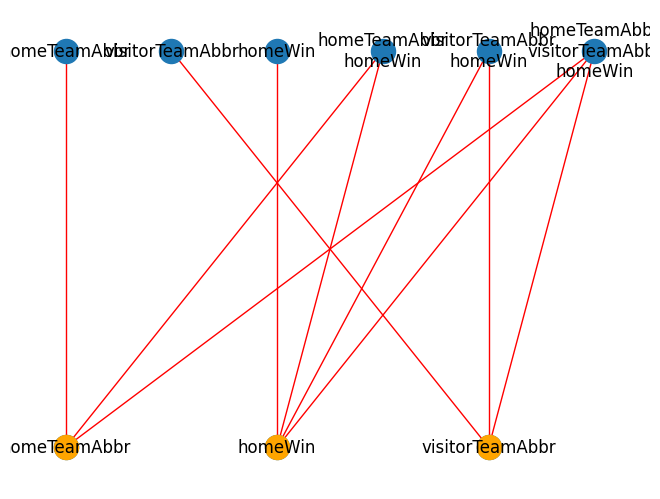

In [61]:
# Print the structure of the Graph to verify its correctness.
top = {team: (i * 2, 0) for i, team in enumerate(sorted(nodes))}
bottom = {factor: (i, 1) for i, factor in enumerate(factors)}
label_dict = {factor: "\n".join(factor.scope()) for factor in G.factors}
label_dict.update({node: node for node in nodes})
nx.draw(
    G,
    pos={**top, **bottom},
    with_labels=True,
    labels=label_dict,
    edge_color="red",
)
nx.draw(
    G.subgraph(nodes),
    node_color="orange",
    pos={**top},
)

### Step 2: Define a model using `MirrorDescentEstimator`

In [41]:
# Initialize model
estimator = MirrorDescentEstimator(model=G, data=games)
marginals = [tuple(i.scope()) for i in G.factors]
observed_factor_dict = FactorDict.from_dataframe(df=games, marginals=marginals)

### Step 3: Learn the marginals 

In [42]:
%%time
tree = estimator.estimate(
    marginals=marginals, metric="L2", iterations=30_000
)
modeled_factor = tree.factors[0]

  0%|          | 0/30000 [00:00<?, ?it/s]

CPU times: user 18.4 s, sys: 2.53 s, total: 20.9 s
Wall time: 21.4 s


### Step 4: View the true marginals against estimated marginals

In [54]:
# Compare a one-way marginal against a modeled clique.
print("Observed")
print(observed_factor_dict[("homeWin",)])
print("Modeled")
print(modeled_factor.marginalize(["homeTeamAbbr", "visitorTeamAbbr"], inplace=False))

Observed
+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |       123.0000 |
+---------------+----------------+
| homeWin(win)  |       159.0000 |
+---------------+----------------+
Modeled
+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |       123.0000 |
+---------------+----------------+
| homeWin(win)  |       159.0000 |
+---------------+----------------+


In [55]:
# Compare a larger clique against the true marginals.
print("Observed")
print(observed_factor_dict[("visitorTeamAbbr", "homeWin")].values.flatten())
print("Modeled")
print(modeled_factor.marginalize(["homeTeamAbbr"], inplace=False).values.flatten())

Observed
[2. 7. 2. 7. 7. 1. 4. 4. 0. 9. 2. 7. 3. 5. 3. 6. 4. 5. 3. 5. 6. 3. 5. 6.
 4. 5. 5. 3. 5. 3. 7. 2. 3. 5. 5. 5. 2. 6. 4. 5. 5. 4. 3. 5. 4. 5. 2. 7.
 3. 5. 5. 5. 5. 4. 4. 5. 7. 2. 5. 5. 1. 7. 3. 6.]
Modeled
[2.0000000e+00 7.0000000e+00 2.0000000e+00 7.0000000e+00 7.0000000e+00
 1.0000000e+00 4.0000000e+00 4.0000000e+00 5.9924031e-11 9.0000000e+00
 2.0000000e+00 7.0000000e+00 3.0000000e+00 5.0000000e+00 3.0000000e+00
 6.0000000e+00 4.0000000e+00 5.0000000e+00 3.0000000e+00 5.0000000e+00
 6.0000000e+00 3.0000000e+00 5.0000000e+00 6.0000000e+00 4.0000000e+00
 5.0000000e+00 5.0000000e+00 3.0000000e+00 5.0000000e+00 3.0000000e+00
 7.0000000e+00 2.0000000e+00 3.0000000e+00 5.0000000e+00 5.0000000e+00
 5.0000000e+00 2.0000000e+00 6.0000000e+00 4.0000000e+00 5.0000000e+00
 5.0000000e+00 4.0000000e+00 3.0000000e+00 5.0000000e+00 4.0000000e+00
 5.0000000e+00 2.0000000e+00 7.0000000e+00 3.0000000e+00 5.0000000e+00
 5.0000000e+00 5.0000000e+00 5.0000000e+00 4.0000000e+00 4.0000000e+00
 5.000

In [49]:
# Out of clique inference for a game that has not yet occured.
query_factor = BeliefPropagation(tree).query(
    variables=["homeWin"],
    evidence={"homeTeamAbbr": "DAL", "visitorTeamAbbr": "SF"},
    joint=True,
    show_progress=True,
)
print(query_factor)

+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |         0.4524 |
+---------------+----------------+
| homeWin(win)  |         0.5476 |
+---------------+----------------+
